# PA1: Poly2mask

实现扫描线将给定的多边形转变为梯形mask, 辅助函数和整体框架已实现, 请填补`poly2mask`函数中缺失的部分, 最终效果如下图:
![pa1_show](./data/pa1_show.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


`line_inter`求直线AB和CD的交点.

`get_trapezoids`接收相邻两条扫描线和多边形的交点`bottom_inter`(下底交点)/`top_inter`(上底交点), 返回两条扫描线之间能构成的梯形列表.

In [2]:
def line_inter(A, B, C, D):
    return A + (B - A) * np.cross(C - A, D - C) / np.cross(B - A, D - C)


def get_trapezoids(top_inter, bottom_inter):
    assert len(top_inter) % 2 == 0 and len(top_inter) == len(bottom_inter)

    if len(top_inter) == 0:
        return []

    top_inter = top_inter[np.argsort(top_inter[:, 0])]
    bottom_inter = bottom_inter[np.argsort(bottom_inter[:, 0])]

    trape_list = list()
    for i in range(0, len(bottom_inter), 2):
        trape_list.append(
            np.concatenate([top_inter[[i, i + 1]], bottom_inter[[i + 1, i]]])
        )
    return trape_list


`poly2mask`流程:
1. 接收多边形`poly`, 将顶点按照Y从小到大排序, 遍历顶点.
2. 利用`line_inter`函数求当前扫描线作为梯形上底时和多边形的交点`top_inter`.
3. (当前扫描线为首条时跳过此步) 由上一条扫描线作为梯形下底, 当前扫描线作为梯形上底, 调用`get_trapezoids`函数得到当前扫描线和上一条扫描线之间的梯形.
4. 更新当前顶点`idx`相邻的边: 若已遍历过从`edge_set`中删除, 未遍历过则加入`edge_set`.
5. 利用`line_inter`函数求当前扫描线作为梯形下底时和多边形的交点`bottom_inter` (遍历到下条扫描线时才会用到).

In [3]:
def poly2mask(poly):
    N = len(poly)

    # Q1: sort indices of vertices by Y (use np.argsort)
    sorted_indices = np.argsort(poly[:, 1])

    edge_set = set()
    trape_list = list()
    bottom_inter = None

    for idx in sorted_indices:
        cur_y = poly[idx][1]

        top_inter = list()
        for e in edge_set:
            # Q2: get intersection of edge e and line Y = cur_y
            inter = line_inter(
                poly[e], poly[(e + 1) % N], np.array([0, cur_y]), np.array([1, cur_y])
            )
            top_inter.append(inter)

        if bottom_inter:
            trape_list.extend(
                get_trapezoids(np.stack(bottom_inter), np.stack(top_inter))
            )

        le_idx = (idx + N - 1) % N  # left neighbor vertex
        if poly[le_idx, 1] <= cur_y:  # if the left edge is lower than cur_y
            # Q3: remove edge le_idx from edge_set
            edge_set.remove(le_idx)
        else:
            # Q4: add edge le_idx into edge_set
            edge_set.add(le_idx)

        ri_idx = (idx + 1) % N  # right neighbor vertex
        if poly[ri_idx, 1] <= cur_y:  # if the right edge is lower than cur_y
            # Q5: remove edge idx from edge_set
            edge_set.remove(idx)
        else:
            # Q6: add edge le_idx into edge_set
            edge_set.add(idx)

        bottom_inter = list()
        for e in edge_set:
            # Q7: get intersection of edge e and line y = cur_y
            inter = line_inter(
                poly[e], poly[(e + 1) % N], np.array([0, cur_y]), np.array([1, cur_y])
            )
            bottom_inter.append(inter)

    return trape_list


运行下面代码块得到可视化结果, 验证代码实现的正确性.

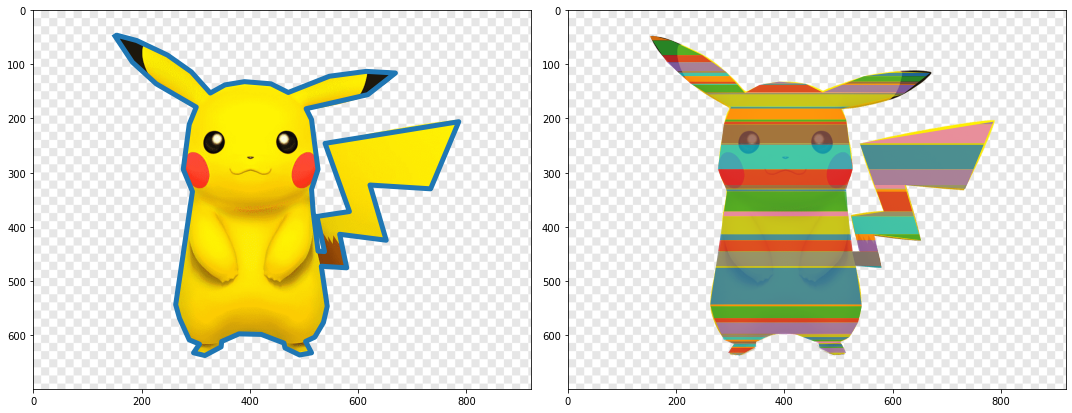

In [4]:
img = Image.open("./data/pa1.png")
with open("./data/pa1.txt", "r") as f:
    poly = []
    for line in f.readlines():
        x, y = map(int, line.split(","))
        poly.append([x, y])
    poly = np.array(poly)

ax = plt.subplots(1, 2, figsize=(15, 15))[1]
ax[0].imshow(img)
ax[0].plot(poly[:, 0], poly[:, 1], linewidth=5)

ax[1].imshow(img)
trape_list = poly2mask(poly)
for tr in trape_list:
    ax[1].fill(tr[:, 0], tr[:, 1], alpha=0.8)

plt.tight_layout()
plt.show()
